# It's Day 3 of the workshop and I know a lot about Python!

Welcome. Now that we have covered the basics of data analysis in Python, we can dive into more sophisticated statistical analysis. Let's start with linear regression.

# Linear Regression in Python
### Fitting Polynomial Functions to Data

### Introduction 
When looking at the results of experiments, it is critically important to be able to fit curves to scattered data points. The following plot shows the [rotation curve](https://en.wikipedia.org/wiki/Galaxy_rotation_curve) of the NGC3198 disk galaxy as an example of scattered data points that we might want to fit a curve to. The data is from the "Dynamics and Astrophysics of Galaxies" book by Jo Bovy.

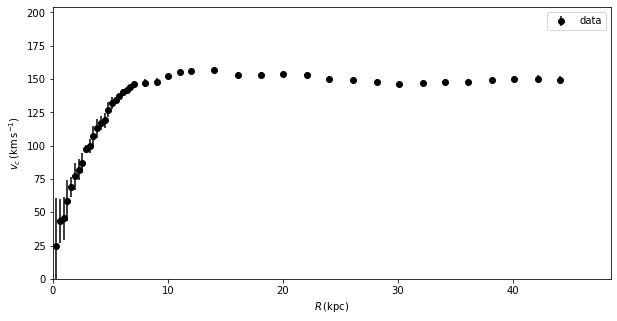

In [ ]:
# Remember to mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# More functions
def plot_rotcurve(gal_data):
    '''
    Plot the rotation curve of the given galaxy.
    INPUTS:
        gal_data (array-like): the galaxy data
    PRODUCES: 
        A scatter plot with errorbars 
    RETURNS:
        NONE
    HISTORY:
       2021-01-05 - Written - Bovy (UofT)
       2022-06-27 - Updated for PASEA
    '''
    plt.figure(figsize=(10, 5))
    plt.errorbar(gal_data['Rad'], gal_data['Vobs'], yerr=gal_data['e_Vobs'],
                 marker='o', ls='none', color='k', zorder=1, label='data')
    plt.xlim(0., 1.1*np.amax(gal_data['Rad']))
    plt.ylim(0., 1.3*np.amax(gal_data['Vobs']))
    plt.xlabel(r'$R\,(\mathrm{kpc})$')
    plt.ylabel(r'$v_c\,(\mathrm{km\,s}^{-1})$')
    plt.legend()
    return

# Read the galaxy data
galaxy_data = pd.read_csv('drive/My Drive/pasea-arp/Day_3/data/NGC3198_rotation_curve.csv')
# We will get back to this plot later, so you can ignore the details for now
plot_rotcurve(galaxy_data)

We will demonstrate that fitting a curve in python is relatively simple, but the theory behind how it works is a bit more involved. To better understand the theory, we will briefly go over fitting a curve to data from scratch.

There are different ways of fitting curves to scattered points. One of the most frequently used is known as Linear Least Squares (LLS). Note, we can fit any order polynomial, not just straight lines, using this method. The formula for generating an LLS fit outputs the constants of the equation ($a_0+a_1x+a_2x^2 +$...) for as many orders as you require based on the degree/order of your fit. The “linear” part of LLS refers to how the distance between the data point and the curve is measured, as we describe momentarily. 

### Fitting a Straight Line to Data

Let's consider the simple case of fitting an order 1 polynomial (a straight line $a_0+a_1x$) to some data. The method of LLS fits a line to your data that minimizes the squared distances between all the points and the line. The reason for choosing the squared distances is that some points will lie below your line, but distances are positive. By squaring we allow for points below the line to also be a “positive” distance away from the line.  The formula requires linear algebra, which some of you may not be familiar with. It looks like this

\begin{equation}
\quad
\begin{pmatrix} 
N & \sum x_i \\
\sum x_i & \sum x_{i}^2
\end{pmatrix}
\begin{pmatrix}
a_1 \\
a_0 \\
\end{pmatrix}=
\begin{pmatrix}
\sum y_i \\
\sum x_i y_i
\end{pmatrix}
\end{equation}

This may look a little scary, but its not hard to implement. $N$ is the number of data points you are trying to fit to. To enter the $x$ sums, simply take your x array (such as the array of radii $R\,[\mathrm{kpc}]$ above), and run `np.sum` on them (squared as required). The $y_i$ are the $y$ values of the data points (e.g., the rotational velocities $v_c\,[\mathrm{km\,s}^{-1}]$ above), which can be multiplied by the $x$ arrays within the `np.sum` function. This is the linear case, where LLS outputs a slope $a_1$ and and a y-intercept $a_0$. 

The above formula can be generalized to fit any order polynomial to a set of data.

Since we know $N$, $x_i$, and $y_i$, we just have to figure out how to do matrix multiplication in python. If we remember (or crash course) our linear algebra, to get the $a_0, a_1$ on it's own, we need to multiply both sides *on the left* by the *inverse* of the (N...) array. So we arrive at:

\begin{equation}
\quad
\begin{pmatrix}
a_1 \\
a_0 \\
\end{pmatrix}=
\begin{pmatrix} 
N & \sum x_i \\
\sum x_i & \sum x_{i}^2
\end{pmatrix}^{-1}
\begin{pmatrix}
\sum y_i \\
\sum x_i y_i
\end{pmatrix}
\end{equation}

where the inverse of the (N...) matrix is now being dotted into the ($\sum y_i$...) array. The functions you'll find useful when setting this up:
- np.linalg.inv
- np.dot

Remember that to set up multidimensional arrays, the format is np.array( [ [a,b,c,...] , [d,e,f,g,...],...])
that is, lists nested inside a list nested inside the function call. For example, the (N...) matrix can be setup as np.array( [ [N, np.sum($x_i$)], [np.sum($x_i$), np.sum($x_i$**2)] ] ).

### Loading the Data 
You should have access to a file called `data.txt` in the `pasea-arp/Day_3/data` directory you mounted on your drive. This contains synthetic data we are going to be fitting before we dive into the galaxy rotation curve above. You can load it into python using the `np.loadtxt` function. You'll want to end up with an array of $x$ values and an array of $y$ values.

In [ ]:
# Your code here: Load data and put into variables named x, y
x, y = np.loadtxt('drive/My Drive/pasea-arp/Day_3/data/data.txt', unpack=True)

Once you've done that, you can use the given code to generate a plot to see what data we are fitting.

Text(0.5, 1.0, 'Data to Fit')

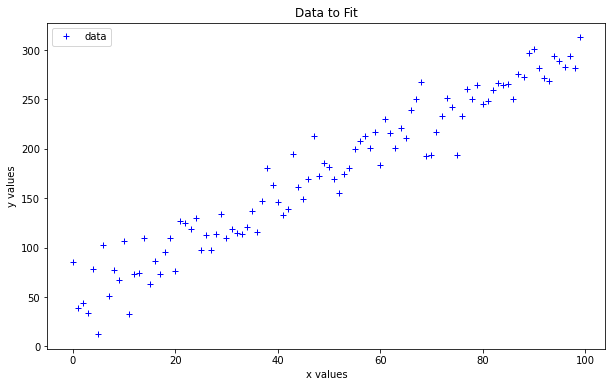

In [4]:
# Size of figure
plt.rcParams['figure.figsize'] = (10, 6)
# Plot data
plt.plot(x, y, 'b+', label='data')
plt.legend()
plt.xlabel('x values')
plt.ylabel('y values')
plt.title('Data to Fit')

Let's define a function called "linear_fit" that implements the equations given above and returns two values: the slope $a_1$ and the y-intercept $a_0$. 

In [9]:
def linear_fit(x_data, y_data):
    # Fill in code here
    N = len(x_data)
    array_1 = np.array([[N, np.sum(x_data)], [np.sum(x_data), np.sum(x_data**2)]])
    array_2 = np.array([[np.sum(y_data)] ,[np.sum(y_data*x_data)]])
    array_1_inv = np.linalg.inv(array_1)
    out_arr = np.dot(array_1_inv, array_2)
    intercept, slope = out_arr[0], out_arr[1]
    return slope, intercept

In [10]:
linear_fit(x, y)

(array([2.57251848]), array([47.7249833]))

Great! So now we have the y-intercept and slope of our "best fit" to the data. From a scientific perspective, we are basically done - it's almost always the values of the slope and intercept that are of interest to us when fitting. But just to see what we've accomplished, let's plot the best fit line over our data:

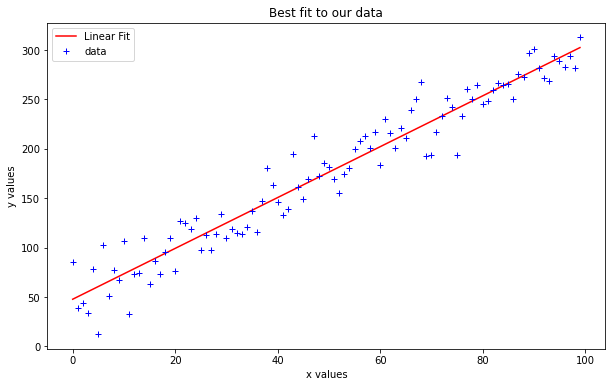

In [11]:
def plot_fit(x, y):
    slope, intercept = linear_fit(x, y)
    fit_line = slope*x + intercept
    plt.plot(x, fit_line, 'r', label='Linear Fit')
    plt.plot(x, y, 'b+',label='data')
    plt.legend()
    plt.xlabel('x values')
    plt.ylabel('y values')
    plt.title('Best fit to our data')
    plt.show()

plot_fit(x,y)

### Evaluating the Fit
So we have a fit to our data. Is it a good fit? Visually, it seems so. But we can be a little bit more quantitative. 

To do so, we are going to evaluate the **residuals,** that is, the *difference* between the prediction of our fit and our data itself. Given that our data has no uncertainty (at least, none that has been specified), this is easy to calculate. Fill in the residual function below to simply return the difference between the fit and the data, along with a single quantity that is the sum of those residuals. As an arbitrary convention, subtract the fit from the data, instead of the converse.

In [12]:
def return_residuals(x, y):
    slope, intercept = linear_fit(x, y)
    fit_line = slope*x + intercept
    residuals = y - fit_line
    return residuals, np.sum(residuals)

In [13]:
residuals, sum_residuals = return_residuals(x, y)
print(sum_residuals)

-7.901235221652314e-12


If we take a look at the sum of the residuals, we notice it's an absurdly small value, something like -8e-12. This means that though the spread in residuals might be large, on average, the fit overpredicts the data and underpredicts the data in equal amounts, which is a sign of a good fit.

### Higher Order Polynomial Fits

Alright, so we have successfully fit a straight line (polynomial order 1) to our data. But what if the data were better described by a quadratic? It may look linear when we plot it, but it might be that the "section" of the data we have access to represents a small one, and we can't see the overall curvature well. 

We can fit any order of polynomial to our data (being careful to avoid over-fitting - remember, a high enough order polynomial can fit *any* set of data with 0 residual, but will look pretty wacky). But, instead of going through the pain of constructing a 3x3 array in the way we did above, let's go ahead and utilize the handy function created for the purpose in the Numpy module - since we now know how it works. 

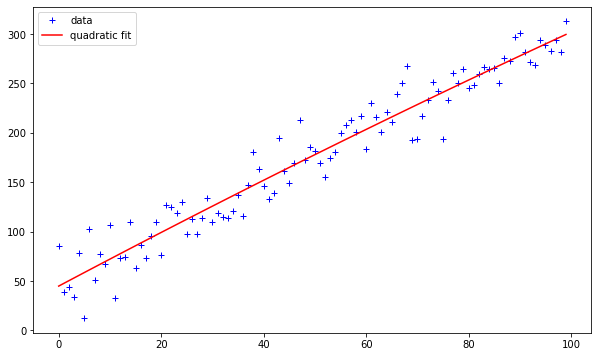

In [14]:
def quadratic_fit(x, y):
    fit_coefficients = np.polyfit(x, y, 2)
    a2, a1, a0 = fit_coefficients[0], fit_coefficients[1], fit_coefficients[2]
    return a2, a1, a0

def plot_quadratic_fit(x, y):
    a2, a1, a0 = quadratic_fit(x, y)
    fit_line = x**2*a2 + x*a1 + a0
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x, fit_line, 'r', label='quadratic fit')
    plt.legend()
    plt.show()
    
plot_quadratic_fit(x, y)

This looks like it could be a decent fit as well, though it doesn't look as good as the linear fit. In fact, if you print them out, you'll see that `np.polyfit` is telling us that it thinks that *if* this data is quadratic, the quadratic coefficient is very small; the remaining linear and constant coefficients are very similar to those in our linear fits. Let's take a look at the residuals:

In [15]:
def quadratic_residuals(x, y):
    a2, a1, a0 = quadratic_fit(x, y)
    fit_line = x**2*a2 + x*a1 + a0
    residuals = y - fit_line
    return residuals, np.sum(residuals)

q_residuals, q_residual_sum = quadratic_residuals(x, y)
print(q_residual_sum)

8.206768598029157e-12


The net sum of the residuals for the quadratic case is similar to the linear case. So it would appear that the linear fit is better here, e.g., the data most likely *are* linear in nature. 

Alright, so I'll fess up. The data indeed are linear; we constructed the dataset by taking a perfectly straight line and adding in Gaussian-distributed noise to make it look more like the type of data we might take in a laboratory experiment. 

As a note though, that means situations like this, where one order of fit is demonstrably and majorly better than another, rarely actually happens. Even when *nature* chooses a truly, fundamentally linear relation between two measurable variables, we can almost never obtain measurements of that relation so perfectly distributed around the true values so as to find that the linear (or any other order) fit is the best. In reality, we tend to simply try to use the lowest order fit that adequately describes our data. 

This isn't too difficult - if you, for example, plot the residuals for each data point for both the linear and quadratic fits, you'll find they look similar in form. Typically, if the data truly were quadratic, the linear residuals would have a strong functional form to them (an under, then over, then under fit).

Now let's try to fit a quadratic to the disk galaxy rotation curve we plotted above.

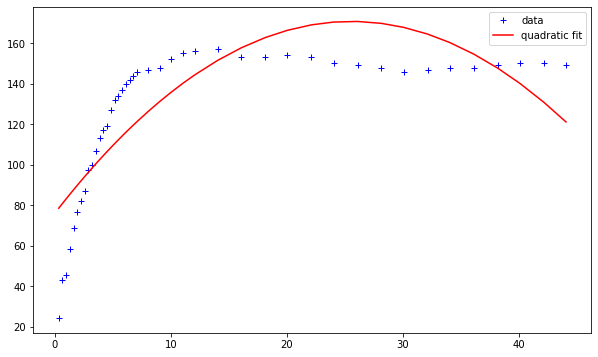

In [16]:
# Your code here - use the `galaxy_data` defined above
plot_quadratic_fit(galaxy_data['Rad'], galaxy_data['Vobs'])

Now plot the quadratic residuals

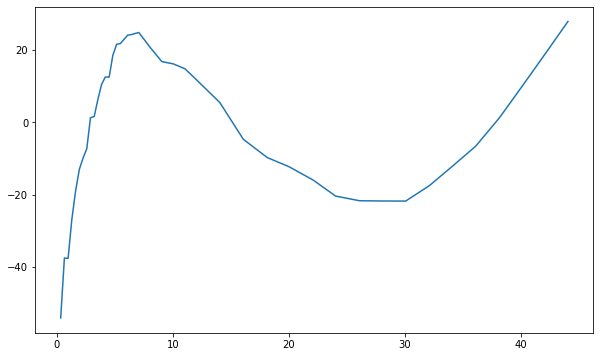

In [17]:
# Your code here
q_residuals, q_residual_sum = quadratic_residuals(galaxy_data['Rad'], galaxy_data['Vobs'])
plt.plot(galaxy_data['Rad'], q_residuals)

We see that the residuals have a strong functional form to them (as described above). This means that we need a higher order polynomial to fit this curve. But would increasing the order of the polynomial solve the problem?

No, because this curve is functional in nature, but not necessarily polynomial. An alternative is to fit a model of a disk rotation curve to this galaxy. In astronomy, we are often dealing with complex physical phenomena that we aim to describe using well-developed theoretical models. By comparing models to observations, we can find areas where our theory is lacking, thereby improving our astrophysical knowledge.

Modeling a disk rotation curve requires you to have some understanding galactic dynamics. Since that is not a prerequisite for this tutorial, we have provided a fitted model in the file `pasea-arp/Day_3/data/NGC3198_rotation_curve_model.csv`, which you can read and plot using the following code:

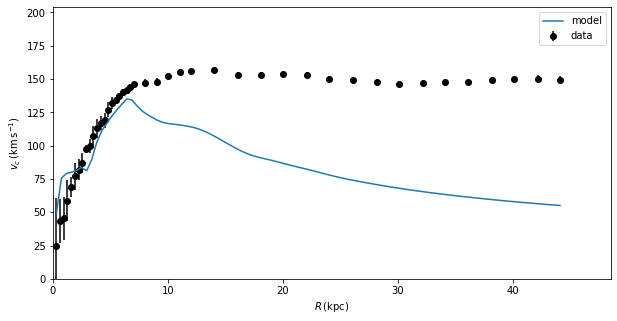

In [ ]:
rot_curve_model = np.loadtxt('drive/My Drive/pasea-arp/Day_3/data/NGC3198_rotation_curve_model.csv')
plot_rotcurve(galaxy_data)
plt.plot(rot_curve_model[0], rot_curve_model[1], label='model')
plt.legend()

In the above plot, the x-axis represents Galactocentric radius (distance from the centre of the galaxy) $R$ in kpc. The sun is located in the Galactic disk at around $R\approx8$ kpc. The y-axis shows the rotational or orbital velocities (think speeds!) of stars or gas observed at a given radius in the disk galaxy.

***

#### Q - We see that the model agrees with the data near the centre of the galaxy, but deviates significantly as $R$ increases. Why is this so?
***

The answer to the above question is not easy. So, if you weren't able to answer it yourself, let's find an answer together! We'll start by taking a step back and understanding the physics underlying the rotation curve of a disk galaxy. The main theory we need to understand here is that of gravity. In general, the speed at which an object revolves around the centre of an orbital system depends on the amount of mass enclosed inside the object's orbit and its orbital radius. We can show this for an object revolving around a spherically symmetric mass distribution using Newton's law of universal gravitation, the shell theorem, and the equations for circular motion - [this article](https://imagine.gsfc.nasa.gov/features/yba/CygX1_mass/gravity/index.html) provides a simple explanation. Thus, at the same orbital radius, the rotational velocity increases with the enclosed mass. On the other hand, if the radius increases without a change in the mass, the velocity decreases. 

Let's look at the orbital velocities of the planets in our Solar system as an example.

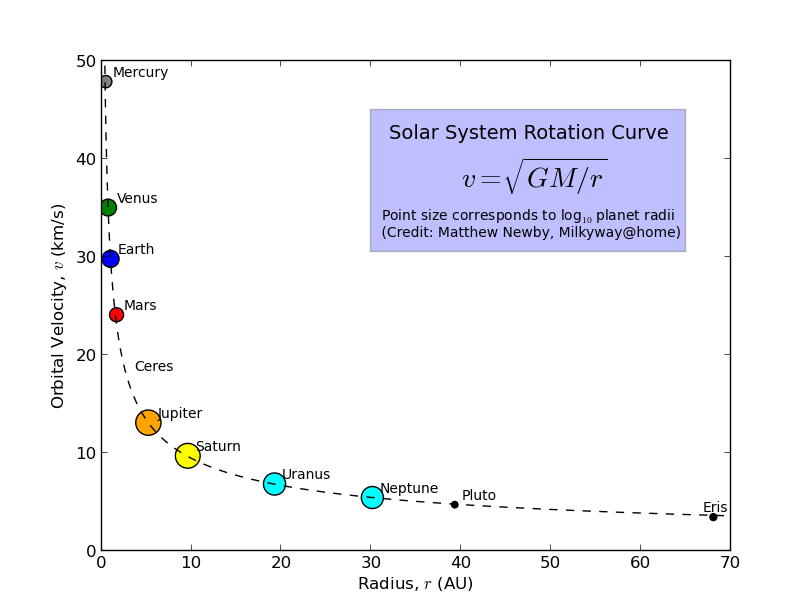

In [ ]:
from IPython.display import Image
Image('drive/My Drive/pasea-arp/Day_3/imgs/ss_rotation_curve.png')

The mass inside the planetary orbits is dominated by that of the Sun. Thus, the enclosed mass is approximately the same for all the planets, and their velocities decrease with distance. We can come to the same conclusion using the Kepler’s third law. The same applies to moons orbiting a planet.

In the case of NGC 3198, the enclosed mass is not just concentrated at the centre. It is distributed as stars and gas across the galaxy. However, the outer parts of the galaxy have very few stars/gas (as seen by observations), so the rotation curve is expected to decrease (as illustrated by the plot labelled "model" above). But the observed rotation curve of NGC 3198 (and several other disk galaxies) is flat with increasing radius. This is where dark matter comes in! It is generally accepted that large amounts of **dark matter** is ditributed across the galaxy causing the stars and gas in the outer parts orbit faster than expected. Big discovery!

Fitting data is a **huge** aspect of data analysis, and this tutorial barely scratches the surface. How do we fit if we have differing uncertainties on our data points? What if both the $x$ and $y$ measurements have associated uncertainties? (Hint: this gets very complicated). What if we are fitting in multidimensional parameter spaces? How do we fit curves that are functional in nature, but not polynomials (like Gaussians, exponentials, compositions of other functions, or even simulator models like above)? All these cases are relevant and important - and will partly be addressed in further tutorials! Now, we will move on to the next part of this tutorial, **classification** using **logistic regression**.

# Logistic Regression in Python
 

In the first part of this tutorial, you learnt how to perform linear regression. Regression is a machine learning technique that fits a curve to discrete data points $\{(x_i, y_i) \, | \, i=1, \dotsc, N\}$ to predict a continuous quantity $y$ given $x$. Did we just say **machine learning**? Yes!

You might ask why linear regression is considered machine learning. The reason is that a regression algorithm *learns* some relationship or mapping between input $x_i$ and output $y_i$ variables of a dataset to *predict* $y$ for any given $x$. It thus achieves the goal of machine learning: to learn from example data without being explicitly programmed (reference: Mattab, HPE Blog, UK & Ireland). 

Another important machine learning approach is that of **classification**. It classifies data into different groups based on their properties. Particularly, it predicts a discrete quantity $y$ given $x$ where $y$ now represents a class label. Several classification methods are available, but we are going to work with only one here: **logistic regression**. If logistic regression is a classification technique, why is it called regression? This is because it predicts a continuous quantity $p(y=1)$ for a given $x$, which is then converted to a class label $y=0$ or $y=1$ based on some threshold value, e.g., $p = 0.5$. Here $p$ represents probability.

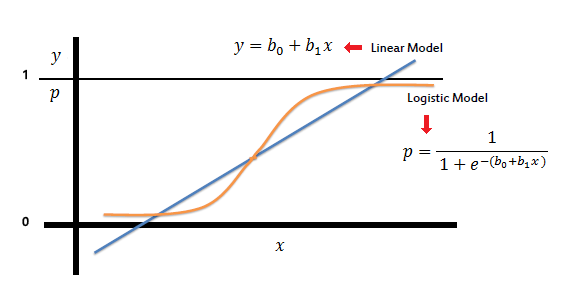

In [9]:
from IPython.display import Image
Image('imgs/linear_vs_logistic.png')

The probability $p(y=1)$ is constructed using the non-linear logistic (or sigmoid) function $\sigma(z) = \frac{1}{1 + e^{-z}}$.
 
We are going to work through an example of classifying variable RR Lyrae stars and nonvariable main sequence stars using Logistic Regression from the "Statistics, Data Mining, and Machine Learning in Astronomy" book by Željko Ivezić, Andrew Connolly, Jacob Vanderplas, and Alex Gray.

Read the data using the following code:

In [15]:
# Code for this section is adapted from the code by
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

X = np.loadtxt('drive/My Drive/pasea-arp/Day_3/data/rrlyrae_X.dat')
y = np.loadtxt('drive/My Drive/pasea-arp/Day_3/data/rrlyrae_y.dat')

Check what the data looks like by printing the shape of the `X` and `y` ndarrays.

In [110]:
# Your code here
print(X.shape, y.shape)

(93141, 4) (93141,)


We have 93141 data points, each representing a star. Four different features (or inputs) are used to classify the stars as variable RR Lyrae $y=1$ or nonvariable main sequence $y=0$. These features are the colours $u-g$, $g-r$, $r-i$, $i-u$ (the order of the colours in `X` is $g-r$, $u-g$, $r-i$, $i-u$ for better 1-color results).

Now split this data into **training** and **test** sets. The logistic regression model will be trained on the training set and its performance will be evaluated using the test set. Use an appropriate `train_fraction` and `test_fraction` below. You can search online what is generally considered a good split fraction.

In [111]:
from sklearn.model_selection import train_test_split

# Your code here
train_fraction = 0.75
test_fraction = 0.25

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_fraction,
                                                    test_size=test_fraction,
                                                    random_state=0)

The training set will now be used to *learn* a mapping between `X` and `y`. You can use one, two, three, or all four colours (features) for the classification. The **for** loop below progressively uses more features for classification.

In [112]:
from sklearn.linear_model import LogisticRegression

# Perform Classification
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

"classifiers" stores a list of four logistic regression models trained on one, two, three, and four features respectively. "predictions" store the predictions on the test set.

Now we compute the decision boundary for the logistic regression model trained on the first two features $g-r$ and $u-g$. The decision boundary is a line separating the two classes, i.e., the nonvariable from variable stars.

In [113]:
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

Let's plot the decision boundary along with the training dataset to see what the model learned.

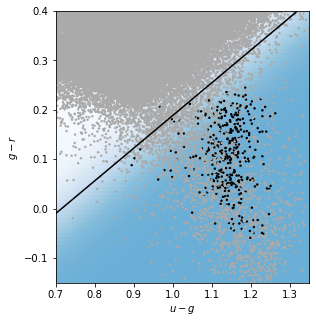

In [114]:
# Plot the results
fig = plt.figure(figsize=(10, 5))

# Plot data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train,
                s=6, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.Blues, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 2)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

plt.show()

Let's plot the decision boundary with the test set to evaluate the predictions.

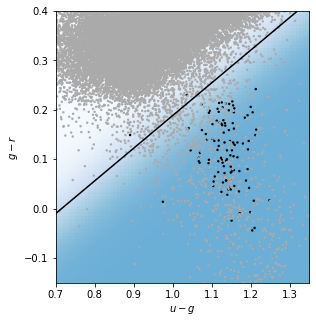

In [87]:
# Plot the results
fig = plt.figure(figsize=(10, 5))

# Plot data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test,
                s=6, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.Blues, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 2)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

plt.show()

***

#### Q - We see that most of the variable RR Lyrae stars (black dots) are classified into one group (bottom right of the plot). We also see that while most nonvariable main sequence stars belong to the other group (top left of the plot), some of them have been misclasssified as being part of the RR Lyrae group. Why is this so?
***

We can quantitatively evaluate the performance of our classification using some metrics, particularly, contamination and completeness. Refer to the this [code](https://www.astroml.org/book_figures/chapter9/fig_rrlyrae_logreg.html#book-fig-chapter9-fig-rrlyrae-logreg) to learn how to calculate these quantities.

In conclusion, logistic regression allows us to perform binary classification, i.e., classifying two different groups of data. Logistic regression can also be extended to classify multiple groups. In addition, logistic regression has important connections with neural networks (which will be covered in the next tutorial). It can be thought of as a 1-neuron neural network. If you want to learn more, refer to this [article](https://thedatafrog.com/en/articles/logistic-regression/).

Congrats! You made it to the end of the tutorial. We hope you enjoyed it, practiced some machine learning with python, and learned something about dark matter and RR Lyrae stars! 

Your next task is to go over *Object Oriented Programming* (OOP) in Python. OOP is such a fundamental concept in programming (in Python, C, C++, R, Java and other OOP languages) that you will have no problem finding resources on this topic. However, if you are relatively new to Python and programming in general, we suggest reading chapter 8 from the [textbook](https://prappleizer.github.io/) and then going over this [guide](https://prappleizer.github.io/Tutorials/OOP/OOP_and_Classes.html). These resources will help you get comfortable with the idea of OOP.